In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from project.utils.geo import get_slice_from_anchor, sel_to_poly_corners
from project.utils.geo_plots import subplots_ortho_dense

In [4]:
fvc = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/').fvc.sel(time='2006').mean('time').compute()

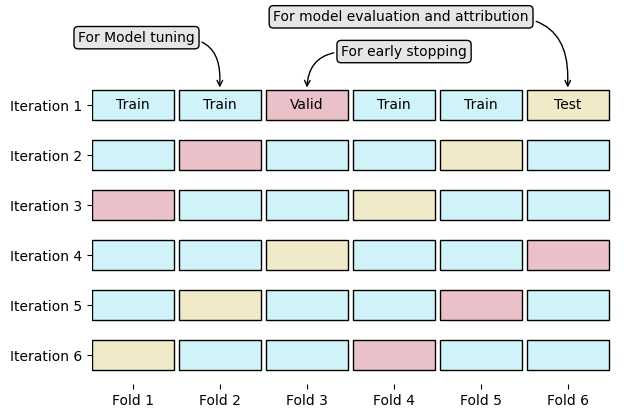

In [7]:
fig, ax = plt.subplots(1, figsize=(7,4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

for fold in range(6):

    for f in range(6):
        if (fold - 3) % 6 == f:
            text = 'Valid'
            color = (204/255, 102/255, 119/255)
        elif (fold) % 6 == f:
            text = 'Test'
            color = (221/255, 204/255, 119/255)
        else:
            text = 'Train'
            color = (136/255, 204/231, 238/255)
        ax.barh([f'Iteration {6-fold}'], [0.94], left=[-0.47 + f], color=(*color, 0.4), edgecolor='k', height=0.6)
        if fold == 5:
            ax.text(f, fold, text, ha='center', va='center')
        ax.set_xticks(range(6))
        ax.set_xticklabels([f'Fold {n}' for n in range(1, 7)]);

ax.annotate(
    'For Model tuning',
    xy=(1, 5.3), xycoords='data', ha='center',
    xytext=(-60, 35), textcoords='offset points',
    bbox=dict(boxstyle='round', fc='0.9'),
    arrowprops=dict(arrowstyle='->',
                    connectionstyle='angle,angleA=0,angleB=90,rad=40'))        

ax.annotate(
    'For early stopping',
    xy=(2., 5.3), xycoords='data', ha='center',
    xytext=(70, 25), textcoords='offset points',
    bbox=dict(boxstyle='round', fc='0.9'),
    arrowprops=dict(arrowstyle='->',
                    connectionstyle='angle,angleA=0,angleB=90,rad=40'))

ax.annotate(
    'For model evaluation and attribution',
    xy=(5., 5.3), xycoords='data', ha='center',
    xytext=(-120, 50), textcoords='offset points',
    bbox=dict(boxstyle='round', fc='0.9'),
    arrowprops=dict(arrowstyle='->',
                    connectionstyle='angle,angleA=0,angleB=90,rad=60'))

fig.savefig('./cross_val_scheme.png', dpi=300, transparent=True, bbox_inches='tight')

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def add_rois(rois, ax):

    bboxes = [get_slice_from_anchor(fvc, *roi, num_chunks_lon=5, num_chunks_lat=3, chunk_size_lon=20, chunk_size_lat=20) for roi in rois]
    polys_corners = [sel_to_poly_corners(bbox) for bbox in bboxes]

    colors = [
        (117/255, 155/255, 255/255),
        (81/255, 53/255, 210/255),
        (220/255, 38/255, 127/255),
        (254/255, 97/255, 0/255),
        (255/255, 176/255, 0/255),
        (255/255, 231/255, 0/255),
    ]
    for i, poly_corners in enumerate(polys_corners):
        fold = i % len(colors)
        color = colors[fold]
        styles = (
            {'lw': 3.0, 'ec': (*color, 0.3)},
            {'lw': 2.5, 'ec': (*color, 0.5)},
            {'lw': 1.6, 'ec': (*color, 0.8)},
            {'lw': 0.7, 'ec': (1.0, 1.0, 1.0, 1.0)},
        )
        for style in styles:
            ax.add_patch(
                mpatches.Polygon(poly_corners, closed=True, fill=False, transform=ccrs.Geodetic(), zorder=999, **style)
            )
            central_point = (np.array(poly_corners[0]) + np.array(poly_corners[2])) / 2
            fontsize = 12
            ax.text(
                *central_point, fold + 1,
                color=color, transform=ccrs.Geodetic(), ha='center', va='center', fontsize=fontsize,
                path_effects=[pe.withStroke(linewidth=1, foreground='w')], zorder=9999)


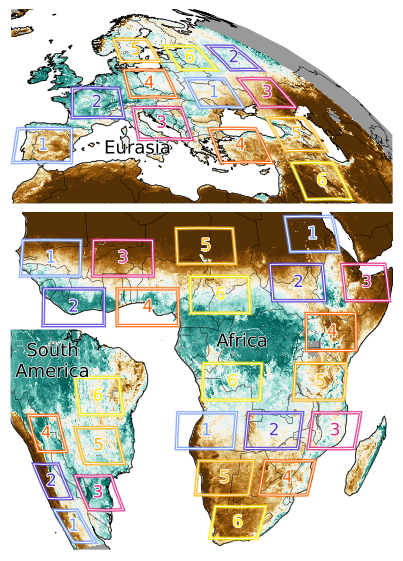

In [52]:
import json

with open('../../project/rois.json', 'r') as f:
    rois = json.load(f)

fig, axes = subplots_ortho_dense()

fvc.plot(cmap='BrBG', add_colorbar=False, ax=axes[0], transform=ccrs.PlateCarree())
fvc.plot(cmap='BrBG', add_colorbar=False, ax=axes[1], transform=ccrs.PlateCarree())
fvc.plot(cmap='BrBG', add_colorbar=False, ax=axes[2], transform=ccrs.PlateCarree())

add_rois(rois['eurasia'], axes[0])
add_rois(rois['africa'], axes[1])
add_rois(rois['south_america'], axes[2])

#fig.savefig('./cross_val_scheme_dense.png', dpi=300, transparent=True, bbox_inches='tight')

In [15]:
ds = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')
ds

<xarray.Dataset>
Dimensions:        (fold: 6, lat: 1140, lon: 1460, time: 7305, hour: 24)
Coordinates:
  * fold           (fold) int64 0 1 2 3 4 5
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * lat            (lat) float32 76.5 76.4 76.3 76.2 ... -37.1 -37.2 -37.3 -37.4
  * lon            (lon) float32 -74.5 -74.4 -74.3 -74.2 ... 71.1 71.2 71.3 71.4
  * time           (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2021-12-31
Data variables:
    fold_mask      (fold, lat, lon) bool dask.array<chunksize=(2, 285, 730), meta=np.ndarray>
    fvc            (time, lat, lon) float32 dask.array<chunksize=(100, 10, 10), meta=np.ndarray>
    lst            (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    mask           (lat, lon) bool dask.array<chunksize=(570, 730), meta=np.ndarray>
    maxrrootdepth  (lat, lon) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    rh_cf          (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    ssrd           (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    t2m            (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    topidx         (lat, lon) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    tp             (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    wtd            (lat, lon) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>

In [16]:
ds.mask.chunk({'lat': 10, 'lon': 10})

<xarray.DataArray 'mask' (lat: 1140, lon: 1460)>
dask.array<rechunk-merge, shape=(1140, 1460), dtype=bool, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 76.5 76.4 76.3 76.2 76.1 ... -37.1 -37.2 -37.3 -37.4
  * lon      (lon) float32 -74.5 -74.4 -74.3 -74.2 -74.1 ... 71.1 71.2 71.3 71.4

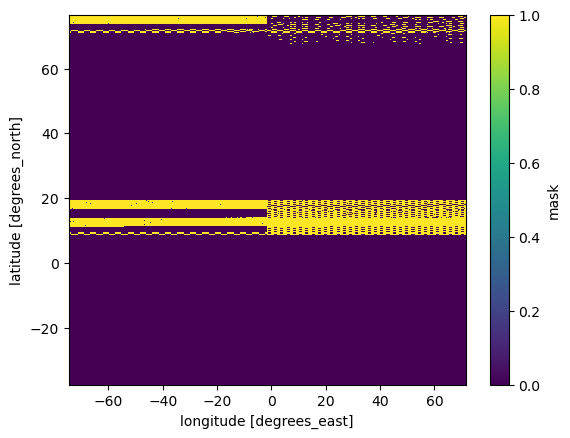

In [17]:
ds.mask.plot()

In [7]:
ds.t2m.where(ds.fold_mask.isel(fold=0))

,Array,Chunk
Bytes,1.06 TiB,0.92 MiB
Shape,"(24, 7305, 1140, 1460)","(24, 100, 10, 10)"
Count,3815306 Tasks,1253264 Chunks
Type,float32,numpy.ndarray


In [13]:
mask_static = (ds.maxrrootdepth.notnull() * ds.topidx.notnull() * ds.wtd.notnull()).compute()

In [5]:
mask_dynamic = (ds.t2m.isel(time=0, hour=0).notnull() * ds.tp.isel(time=0, hour=0).notnull() * ds.rh_cf.isel(time=0, hour=0).notnull() * ds.ssrd.isel(time=0, hour=0).notnull()).compute()

In [6]:
mask_fvc = ds.fvc.sel(time=slice('2005', '2010')).notnull().any('time').compute()

In [7]:
mask_lst = ds.lst.sel(time='2010').notnull().any(('time', 'hour')).compute()

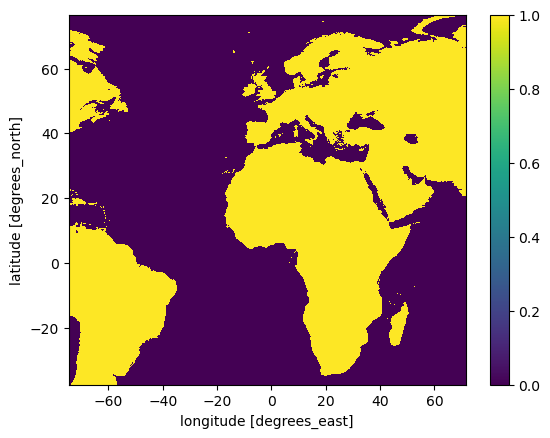

In [8]:
mask_static.plot()

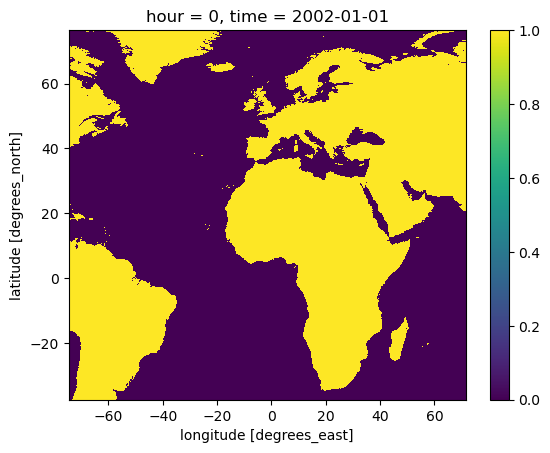

In [9]:
mask_dynamic.plot()

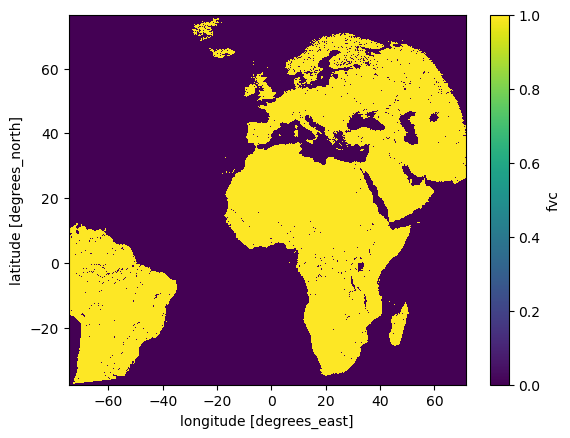

In [10]:
mask_fvc.plot()

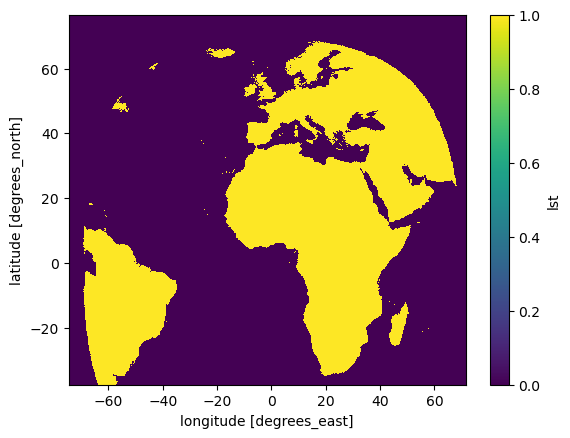

In [11]:
mask_lst.plot()

In [52]:
common_mask = (mask_static * mask_dynamic * mask_fvc * mask_lst).drop(['time', 'hour'])

In [1]:
common_mask

NameError: name 'common_mask' is not defined

In [72]:
import json

In [73]:
with open('../../project/rois.json', 'r') as f:
    rois_json = json.load(f)

rois = []

for key, val in rois_json.items():
    rois.extend(val)

In [74]:
mask = xr.Dataset()
mask['common_mask'] = common_mask
mask['fold_mask'] = xr.zeros_like(common_mask).expand_dims(fold=np.arange(6)).copy()

In [75]:
roi_attr = {}

for fold in range(6):
    fold_rois = [get_slice_from_anchor(common_mask, *roi) for roi in rois[fold::6]]
    for r, fold_roi in enumerate(fold_rois):
        mask['fold_mask'].loc[{**fold_roi, 'fold': fold}] = True
        roi_attr.update(
            {
                f'roi_{r}': {
                    'lon': [fold_roi['lon'].start, fold_roi['lon'].stop],
                    'lat': [fold_roi['lat'].start, fold_roi['lat'].stop]
                }
            }
        )

mask['fold_mask'] =  mask['common_mask'] * mask['fold_mask']
mask['fold_mask'].attrs  = roi_attr

In [76]:
mask.fold_mask

<xarray.DataArray 'fold_mask' (lat: 1140, lon: 1460, fold: 6)>
array([[[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
...
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]]])
Coordinates:
  * lat      (lat) float32 76.5 76.4 76.3 76.2 76.1 ... -37.1 -37.2 -37.3 -37.4
  * lon      (lon) float32 -74.5 -74.4 -74.3 -74.2 -74.1 ... 71.1 71.2 71.3 71.4
  * fold     (fold) int64 0 1 2 3 4 5
Attributes:
    roi_0:    {'lon': [-50.51, -38.589998474121096], 'lat': [-8.49, -14.40999...
    roi_1:    {'lon': [11.49, 23.409999618530275], 'lat': [11.51, 5.589999904...
    roi_2:    {'lon': [26.49, 38.410001525878904], 'lat': [-8.49, -14.4099996...
    roi_3:    {'lon': [17.49, 29.409999618530275], 'lat': [-29.49, -35.410001...
    roi_4:    {'lon': [25.49, 37.410001525878904], 'lat': [59.51, 53.58999847...
    roi_5:    {'lon': [39.49, 51.410001525878904], 'lat': [36.51, 30.59000038...

In [70]:
ds.lon

<xarray.DataArray 'lon' (lon: 1460)>
array([-74.5, -74.4, -74.3, ...,  71.2,  71.3,  71.4], dtype=float32)
Coordinates:
  * lon      (lon) float32 -74.5 -74.4 -74.3 -74.2 -74.1 ... 71.1 71.2 71.3 71.4
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [87]:
ds.sel(fold_rois[5])

<xarray.Dataset>
Dimensions:        (fold: 6, lat: 60, lon: 120, time: 7305, hour: 24)
Coordinates:
  * fold           (fold) int64 0 1 2 3 4 5
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * lat            (lat) float32 36.5 36.4 36.3 36.2 ... 30.9 30.8 30.7 30.6
  * lon            (lon) float32 39.5 39.6 39.7 39.8 ... 51.1 51.2 51.3 51.4
  * time           (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2021-12-31
Data variables:
    fold_mask      (fold, lat, lon) bool dask.array<chunksize=(2, 60, 120), meta=np.ndarray>
    fvc            (time, lat, lon) float32 dask.array<chunksize=(100, 10, 10), meta=np.ndarray>
    lst            (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    mask           (lat, lon) bool dask.array<chunksize=(60, 120), meta=np.ndarray>
    maxrrootdepth  (lat, lon) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    rh_cf          (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    ssrd           (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    t2m            (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    topidx         (lat, lon) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    tp             (hour, time, lat, lon) float32 dask.array<chunksize=(24, 100, 10, 10), meta=np.ndarray>
    wtd            (lat, lon) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>

In [69]:
ds.lon.sel(lon=slice(71.2, 71.4))

<xarray.DataArray 'lon' (lon: 1)>
array([71.3], dtype=float32)
Coordinates:
  * lon      (lon) float32 71.3
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [64]:
ds.fvc.isel(time=0).sel(lon=slice(11.5, 23.41), lat=slice(11.5, 5.6))

<xarray.DataArray 'fvc' (lat: 59, lon: 120)>
dask.array<getitem, shape=(59, 120), dtype=float32, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 11.5 11.4 11.3 11.2 11.1 11.0 ... 6.1 6.0 5.9 5.8 5.7
  * lon      (lon) float32 11.5 11.6 11.7 11.8 11.9 ... 23.0 23.1 23.2 23.3 23.4
    time     datetime64[ns] 2002-01-01
Attributes:
    long_name:  fraction
    units:      -

In [39]:
mask.fold_mask

<xarray.DataArray 'fold_mask' (lat: 1140, lon: 1460, fold: 6)>
array([[[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
...
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]]])
Coordinates:
  * lat      (lat) float32 76.5 76.4 76.3 76.2 76.1 ... -37.1 -37.2 -37.3 -37.4
  * lon      (lon) float32 -74.5 -74.4 -74.3 -74.2 -74.1 ... 71.1 71.2 71.3 71.4
  * fold     (fold) int64 0 1 2 3 4 5

In [24]:
fold_roi

{'lon': slice(-70.5, -58.6, None), 'lat': slice(-29.5, -35.4, None)}

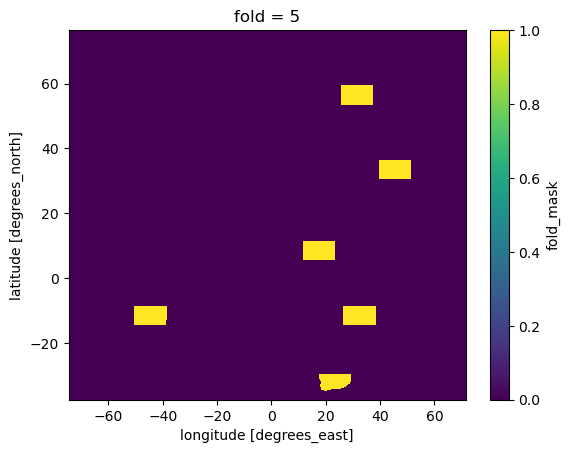

In [21]:
mask.fold_mask.isel(fold=5).plot()

In [88]:
mask

<xarray.Dataset>
Dimensions:      (lat: 1140, lon: 1460, fold: 6)
Coordinates:
  * lat          (lat) float32 76.5 76.4 76.3 76.2 ... -37.1 -37.2 -37.3 -37.4
  * lon          (lon) float32 -74.5 -74.4 -74.3 -74.2 ... 71.1 71.2 71.3 71.4
  * fold         (fold) int64 0 1 2 3 4 5
Data variables:
    common_mask  (lat, lon) bool False False False False ... False False False
    fold_mask    (lat, lon, fold) bool False False False ... False False False

In [12]:
np.argwhere(np.array(ds.fvc.dims) == 'lat').item()

1

In [6]:
ds.fvc.encoding.dims

AttributeError: 'dict' object has no attribute 'dims'

In [ ]:
1460 / 10 * 1140 / 10 * 20 * 365 

In [26]:
xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')

,Array,Chunk
Bytes,45.29 GiB,1.53 MiB
Shape,"(7305, 1140, 1460)","(1000, 20, 20)"
Count,33289 Tasks,33288 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.06 TiB,36.62 MiB
Shape,"(24, 7305, 1140, 1460)","(24, 1000, 20, 20)"
Count,33289 Tasks,33288 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [1]:
import xarray as xr

In [20]:
ds = xr.open_dataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d10_static/soilgrids/v0_5_1/Data/SNDPPT.soilgrid.3600.1800.7.nc')
mn = ds.sel(layer=[1, 2, 3, 4, 5, 6]).mean('layer').compute()

In [25]:
ds

<xarray.Dataset>
Dimensions:    (layer: 7, longitude: 3600, latitude: 1800)
Coordinates:
  * layer      (layer) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0
  * longitude  (longitude) float64 -179.9 -179.8 -179.8 ... 179.8 179.9 180.0
  * latitude   (latitude) float64 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
Data variables:
    SNDPPT     (layer, latitude, longitude) float32 ...
Attributes:
    title:             soilgrids SNDPPT
    version:           v0.5.1
    history:           created: Thu May  5 14:34:16 2022
    provided_by:       https://soilgrids.org
    created_by:        uweber@bgc-jena.mpg.de
    upscaling_method:  average as implemented in the GDAL software
    reference_1:       Hengl, T., Mendes de Jesus, J., Heuvelink, G. B.M., Ru...
    reference_2:       Shangguan, W., Hengl, T., de Jesus, J. M., Yuan, H. an...
    reference_3:       Hengl T, de Jesus JM, MacMillan RA, Batjes NH, Heuveli...

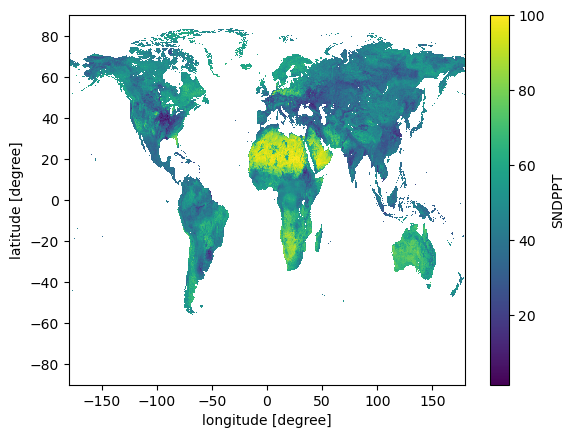

In [23]:
mn.SNDPPT.plot()

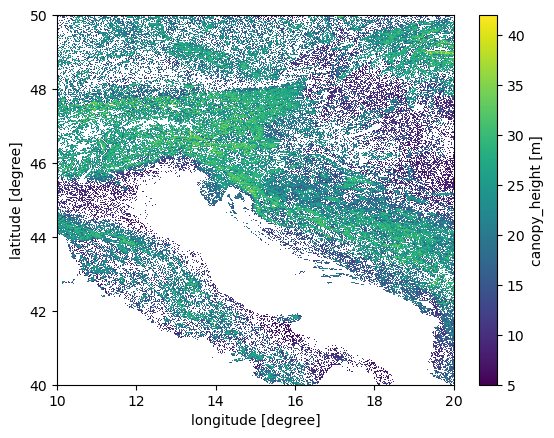

In [17]:
ds.canopy_height.sel(latitude=slice(50, 40), longitude=slice(10, 20)).plot()

In [37]:
ds = xr.open_dataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d083_static/GlobVeg3D/L3C/Data/GlobVeg3D.L3C.4320.2160.nc')

In [38]:
ds

<xarray.Dataset>
Dimensions:    (lon: 4320, lat: 2160)
Coordinates:
  * lon        (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat        (lat) float64 89.96 89.87 89.79 89.71 ... -89.79 -89.88 -89.96
Data variables:
    GlobVeg3D  (lat, lon) float32 ...
Attributes:
    title:         canopy height (forested landscapes in 3D)
    reference:     Simard etal 2011 JGR Mapping forest canopy height globally...
    history:       created Fri May 24 17:18:41 2013
    provided_by:   Marc Simard (marc.simard@jpl.nasa.gov - JPL)
    created_by:    Ulrich Weber (uweber@bgc-jena.mpg.de)
    download_url:  http://lidarradar.jpl.nasa.gov/
    version:       L3C
    method:        Original 1km data has been averaged for dominant landcover...

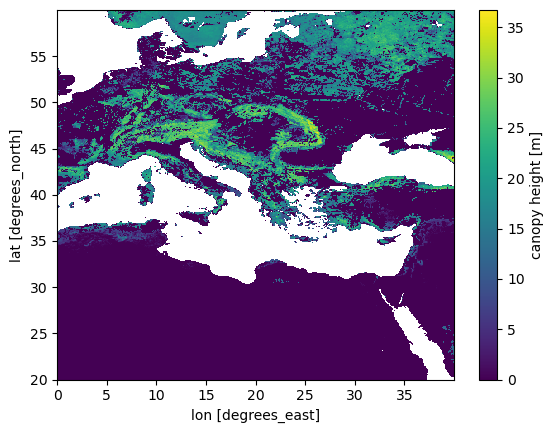

In [13]:
ds.GlobVeg3D.sel(lat=slice(60, 20), lon=slice(0, 40)).plot()

In [50]:
ds = xr.open_dataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d083_static/GlobVeg3D/L3C/Data/GlobVeg3D.L3C.4320.2160.nc')

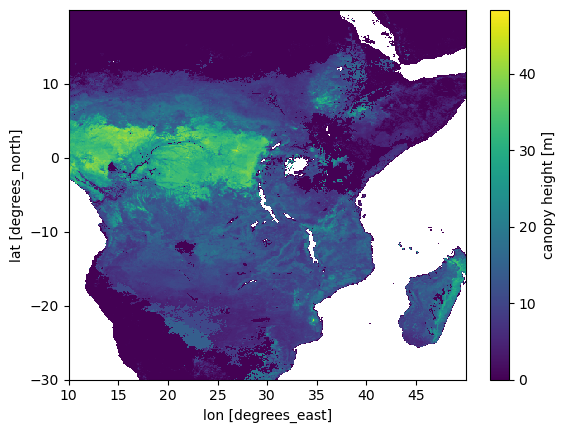

In [51]:
ds.GlobVeg3D.sel(lat=slice(20, -30), lon=slice(10, 50)).plot()

In [52]:
import os

In [55]:
dirpath

'/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_7daily/Leaf_Chlorophyll/v2020/Software'

In [56]:
dirnames

[]

In [59]:
for dirpath, dirnames, files in os.walk(os.path.abspath('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/')):
    for dirname in dirnames:
        #if 'mod44b' in 
        if 'mod44b' in dirname.lower():
            print(f'{dirpath}/{dirname}')

/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d050_annual/MODIS/MOD44B3.006
/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d00416_annual/MODIS/MOD44B3.006
/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d25_annual/MODIS/MOD44B3.006


In [1]:
import xarray as xr

In [17]:
ds = xr.open_dataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d00416_annual/MODIS/MOD44B3.006/Data/Percent_Tree_Cover.86400.36000.2000.nc')
ds

<xarray.Dataset>
Dimensions:             (longitude: 86400, latitude: 36000)
Coordinates:
  * longitude           (longitude) float64 -180.0 -180.0 -180.0 ... 180.0 180.0
  * latitude            (latitude) float64 90.0 89.99 89.99 ... -59.99 -60.0
Data variables:
    Percent_Tree_Cover  (latitude, longitude) float32 ...
Attributes:
    title:        Percent_Tree_Cover - MOD44B3.006
    version:      006
    reference:    Dimiceli, C., Carroll, M., Sohlberg, R., Kim, D.H., Kelly, ...
    history:      created: Fri Dec  7 14:03:44 2018
    provided_by:  https://lpdaac.usgs.gov/dataset_discovery/modis/modis_produ...
    created_by:   uweber@bgc-jena.mpg.de

In [21]:
d = ds.Percent_Tree_Cover.sel(latitude=slice(20, 0), longitude=slice(0, 20)).compute()

In [37]:
dc = ds.coarsen(latitude=20, longitude=20).mean().compute()

KeyboardInterrupt: 

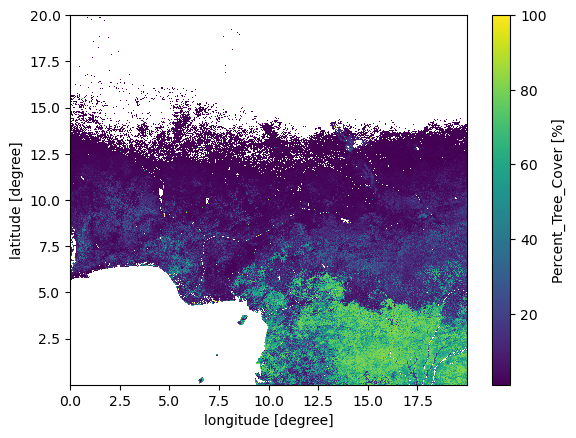

In [23]:
d.plot()

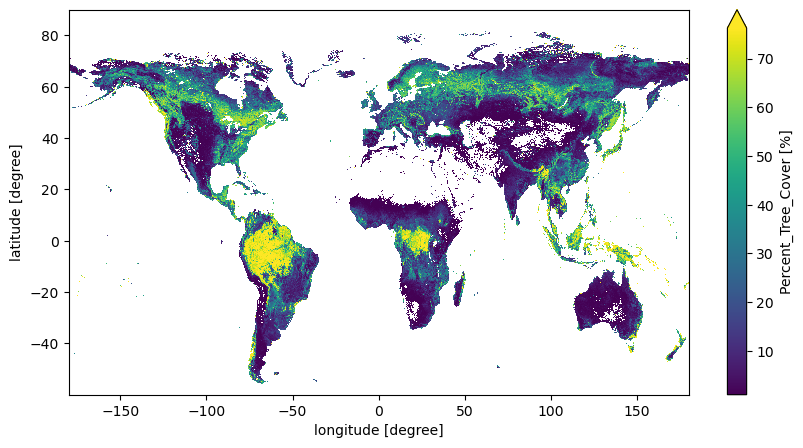

In [29]:
dc.Percent_Tree_Cover.plot(robust=True, figsize=(10, 5))

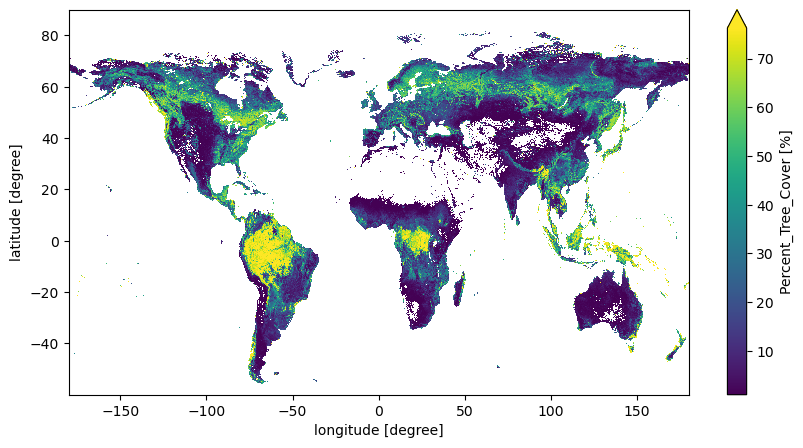

In [ ]:
dc.Percent_Tree_Cover.plot(robust=True, figsize=(10, 5))

In [40]:
ds = xr.open_mfdataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d00416_annual/MODIS/MOD44B3.006/Data/Percent_Tree_Cover.86400.36000.*.nc', combine='nested', concat_dim='years').median('years').compute()
ds

KeyboardInterrupt: 

: 

In [33]:
ds_median = ds.median('years')
ds_median

<xarray.Dataset>
Dimensions:             (longitude: 86400, latitude: 36000)
Coordinates:
  * longitude           (longitude) float64 -180.0 -180.0 -180.0 ... 180.0 180.0
  * latitude            (latitude) float64 90.0 89.99 89.99 ... -59.99 -60.0
Data variables:
    Percent_Tree_Cover  (latitude, longitude) float32 dask.array<chunksize=(800, 1920), meta=np.ndarray>

In [38]:
ds = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/tmp.nc')
ds

<xarray.Dataset>
Dimensions:                     (longitude: 86400, latitude: 36000)
Coordinates:
  * longitude                   (longitude) float64 -180.0 -180.0 ... 180.0
  * latitude                    (latitude) float64 90.0 89.99 ... -59.99 -60.0
Data variables:
    Percent_NonTree_Vegetation  (latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    title:        Percent_NonTree_Vegetation - MOD44B3.006
    version:      006
    reference:    Dimiceli, C., Carroll, M., Sohlberg, R., Kim, D.H., Kelly, ...
    history:      Thu Nov 24 17:19:53 2022: cdo -O ensmedian /Net/Groups/BGI/...
    provided_by:  https://lpdaac.usgs.gov/dataset_discovery/modis/modis_produ...
    created_by:   uweber@bgc-jena.mpg.de
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...